# Numerical Analysis: Final Project

##### Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/Users/ben_nicholson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ben_nicholson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##### Functions

In [2]:
def spline_poly_i(x, i, cs):
    a, b, c, d = cs.c[:, i]
    x0 = cs.x[i]
    return a*(x - x0)**3 + b*(x - x0)**2 + c*(x - x0) + d

# Section A: Mach Number Computation & Error Analysis

# Section B: Thrust Curve Modeling

## EDA

In [3]:
thurst = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/school_work/numerical_analysis/final_project/datasets/Thrust_MainEngine.csv')

thurst

,t_s,Thrust_kN
0,0.000000,821.492110
1,0.040013,823.514291
2,0.080027,817.369258
3,0.120040,815.367970
4,0.160053,817.691475
...,...,...
2995,119.839947,827.464856
2996,119.879960,819.435711
2997,119.919973,833.492598
2998,119.959987,833.656239


Text(0, 0.5, 'Thrust (kN)')

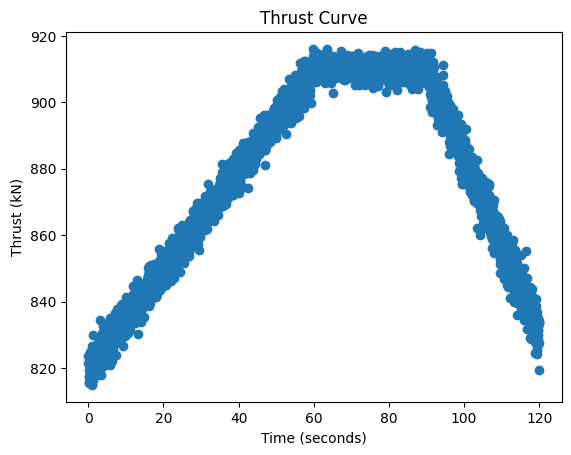

In [4]:
# get the thrust curve
plt.scatter(thurst['t_s'],thurst['Thrust_kN'])
plt.title('Thrust Curve')
plt.xlabel('Time (seconds)')
plt.ylabel('Thrust (kN)')

There are too many points to interpolate, we will select random points throughout the curve to then interpolate.

## Randomize interpolation data

In [5]:
# using then numpy package call the random choice
# this is going to randomly select time values to train the interpolation on

# set the random seed to 42 
np.random.seed(21)
random_thrust_time = np.random.choice(thurst['t_s'].values,size=10)

In [6]:
# now get the values that are located within the random time selection
random_thrust_df = thurst[thurst['t_s'].isin(random_thrust_time)]

Text(0, 0.5, 'Thrust (kN)')

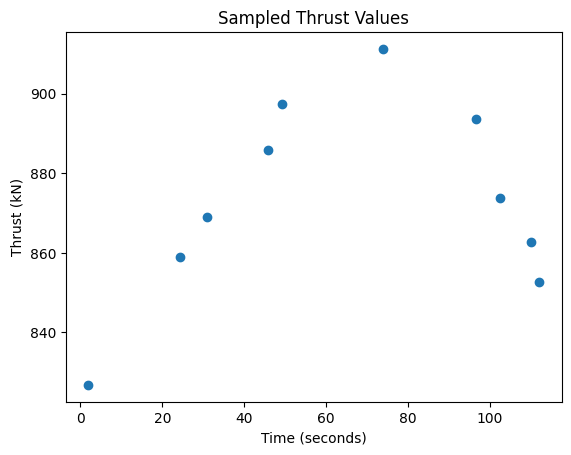

In [7]:
plt.scatter(random_thrust_df['t_s'],random_thrust_df['Thrust_kN'])
plt.title('Sampled Thrust Values')
plt.xlabel('Time (seconds)')
plt.ylabel('Thrust (kN)')

## Create Cubic Spline

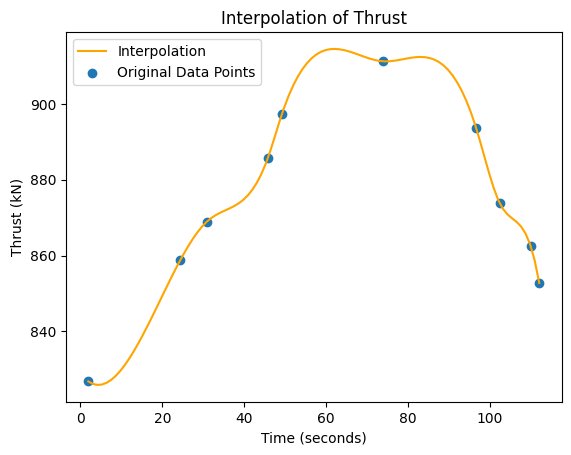

In [8]:
from scipy.interpolate import CubicSpline

x = random_thrust_df['t_s'] # get the 6 random points from the original data
y = random_thrust_df['Thrust_kN'] # get the 6 random values from the original data based on the random x

cs = CubicSpline(x,y) # train the cubic spline on the data

x_pred = np.linspace(x.min(),x.max(),100) # get the x and y values using min and max of x 
y_pred = cs(x_pred)

thrust_df = pd.DataFrame({'t_s':x_pred,'Thrust':y_pred})

plt.plot(x_pred,y_pred,color='Orange',label='Interpolation')
plt.scatter(x,y,label='Original Data Points')
plt.title('Interpolation of Thrust')
plt.xlabel('Time (seconds)')
plt.ylabel('Thrust (kN)')
plt.legend()

In [9]:
# create shape variables
coefficients_n, functions_n = cs.c.shape

print(f'The number of functions are {functions_n} with each having {coefficients_n} coefficients')

The number of functions are 9 with each having 4 coefficients


There are 9 different functions connecting the 10 points, as it is a cubic function there are 4 coeffcients. Lets look at the first spline to see how it is constructed.

In [10]:
# output the first functions coefficients
cs.c[:,0]

array([-3.21433932e-03,  1.70115818e-01, -7.75433690e-01,  8.26813514e+02])

Use the above parameters across the 1st cube spline region

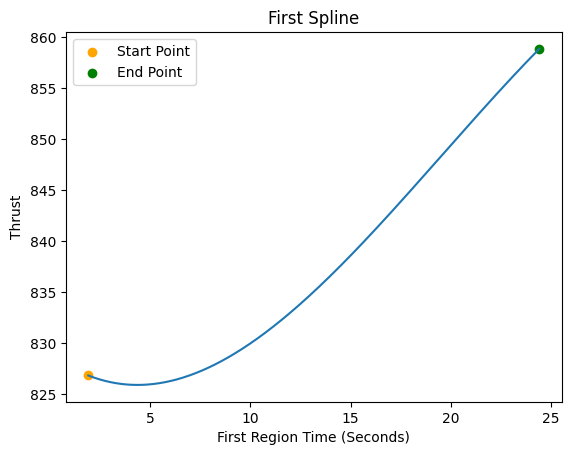

In [11]:
# plot the above coefficients using the spline function
a,b,c,d = cs.c[:,4]

first_region = np.linspace(x.iloc[0],x.iloc[1],1000)

first_spline = spline_poly_i(first_region,0,cs)

plt.plot(first_region,first_spline)
plt.scatter(first_region[0],first_spline[0],color='Orange',label='Start Point')
plt.scatter(first_region[-1],first_spline[-1],color='Green',label='End Point')
plt.title('First Spline')
plt.xlabel('First Region Time (Seconds)')
plt.ylabel('Thrust')
plt.legend()

## Derivative of Cubic Spline Functions

In [12]:
# next we have to compute the derivative of Thrust vs time
cs_derivative = cs.derivative() # this will take the derivative of each original function

Text(0, 0.5, 'Derivative of Thrust (kN)')

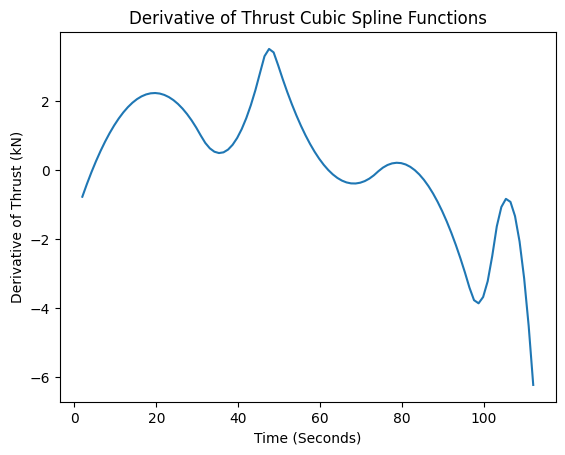

In [13]:
# plot the derivative function
y_pred_derivative = cs_derivative(x_pred)


# plot the derivative funciton
plt.plot(x_pred,y_pred_derivative)
plt.title('Derivative of Thrust Cubic Spline Functions')
plt.xlabel('Time (Seconds)')
plt.ylabel('Derivative of Thrust (kN)')

There is now one less varialbe in the cubic splines.

In [14]:
# combine x_pred and y_pred_derivative
thrust_derivative = pd.DataFrame({'t_s':x_pred,'Thrust_Kn Derivative':y_pred_derivative})

In [15]:
# plot the two functions as normalized values
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

normalized_data_derivative = scaler.fit_transform(thrust_derivative)
normalized_data_thrust = scaler.fit_transform(thrust_df)

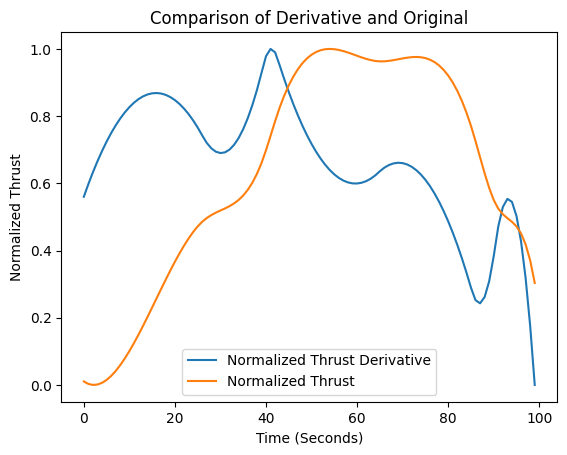

In [16]:
# lets plot the derivative of the first cubic spline
plt.plot(normalized_data_derivative[:,1],label='Normalized Thrust Derivative')
plt.plot(normalized_data_thrust[:,1],label='Normalized Thrust')
plt.xlabel('Time (Seconds)')
plt.ylabel('Normalized Thrust')
plt.title('Comparison of Derivative and Original')
plt.legend()

## Second Order Central Finite Difference

In [17]:
# create a function to find the second order diff
def second_order_diff(cs,x,h):
    derivative = (cs(x+h) - cs(x-h)) / (2 * h)
    return derivative

Lets use different values of h to determine the level required to reach a certain minimum error

In [18]:
h_values = np.linspace(1,0.000001,1000)
errors = []

for values in h_values:
    diff_values = second_order_diff(cs,x_pred,values)
    error = sum((np.abs(diff_values - y_pred_derivative)))

    errors.append(error)

Text(0, 0.5, 'Sum Residual Error')

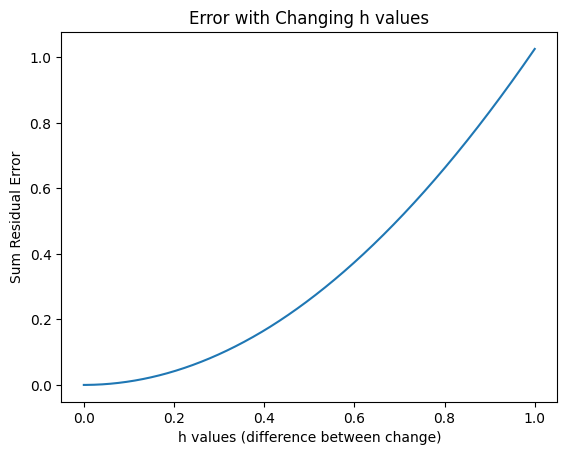

In [19]:
plt.plot(h_values, errors)
plt.title('Error with Changing h values')
plt.xlabel('h values (difference between change)')
plt.ylabel('Sum Residual Error')

Show Burns and ask for what's next.

# Section C: Trajectory Integration

# Section D: Thermal Shield Optimization
We will use 200 nodes to describe a thickness L. The L needs to be determined to understand the thickness of the heat shield.

## EDA

In [20]:
thermal = pd.read_csv('/Users/ben_nicholson/Documents/vs_code/school_work/numerical_analysis/final_project/datasets/HeatShield_Temp-1.csv')

thermal

,t_s,Temp_K
0,0.000000,281.719257
1,0.100033,288.608432
2,0.200067,295.521193
3,0.300100,290.256304
4,0.400133,293.820543
...,...,...
2995,299.599867,1748.509080
2996,299.699900,1760.944797
2997,299.799933,1755.995163
2998,299.899967,1753.858832


Text(0, 0.5, 'Thermal Temperature (K)')

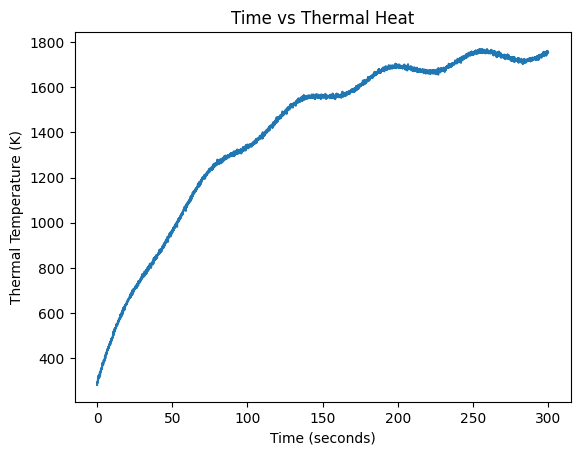

In [21]:
plt.plot(thermal['t_s'],thermal['Temp_K'])
plt.title('Time vs Thermal Heat')
plt.xlabel('Time (seconds)')
plt.ylabel('Thermal Temperature (K)')

## Set up Heat Shield Matrix
The 200 nodes represent the movement of heat at any point from the outside to the inside. So we will construct a 1d hat conduction

In [22]:
import numpy as np

def heat_conduction_system(n, L, T0, Tn, k):
    dx = L / (n + 1)
    a = c = -k / dx**2
    b = 2 * k / dx**2

    A = np.diag([b] * n) + np.diag([a] * (n - 1), 1) + np.diag([c] * (n - 1), -1)
    rhs_vector = np.zeros(n) # the boundary conditions
    rhs_vector[0] -= a * T0 # this is the outside node
    rhs_vector[-1] -= c * Tn # this is the inside node
    return A, rhs_vector

In [23]:
# use the last temperature as an example
last_temp = thermal['Temp_K'].iloc[-1]

In [24]:
A,rhs = heat_conduction_system(200,0.01,last_temp,0,237)

In [25]:
def tridiagonal_LU(A): # this creates the L and U
    n = A.shape[0] 
    L = np.eye(n) # np.eye is used to create an identity matrix
    U = A.copy() # get a copy of the original matrix A

    for i in range(1, n):
        factor = U[i, i-1] / U[i-1, i-1]
        L[i, i-1] = factor
        U[i] = U[i] - factor * U[i-1]

    return L, U

def solve_LU(L, U, b):
    # Forward solve: L y = b
    y = np.zeros_like(b)
    for i in range(len(b)):
        y[i] = b[i] - L[i, :i] @ y[:i]

    # Backward solve: U x = y
    x = np.zeros_like(b)
    for i in reversed(range(len(b))):
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]
    return x


In [26]:
L,U = tridiagonal_LU(A)

In [27]:
temps = solve_LU(L,U,rhs)

Text(0, 0.5, 'Temperature (K)')

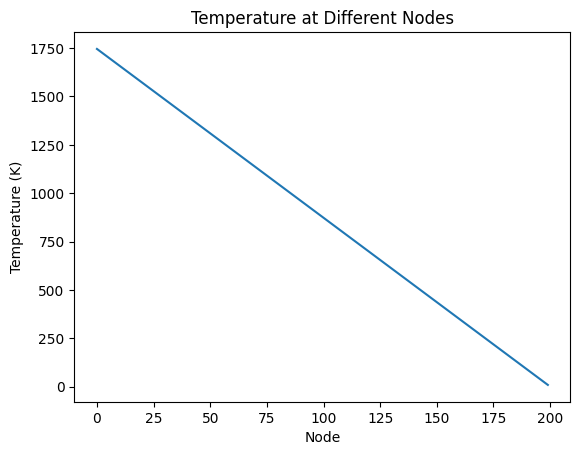

In [28]:
plt.plot(temps)
plt.title('Temperature at Different Nodes')
plt.xlabel('Node')
plt.ylabel('Temperature (K)')

This shows the change in temperature

In [34]:
# compute the condition number
cond_A = np.linalg.cond(A)
print(cond_A)

1.8476284817847226
